# Importing all necessary libraries

In [1]:
import mne
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
from scipy import signal
import copy
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from clusteval import clusteval

# Loading Dataset 
-   Use scipy to load data
-   Create dictionary to extract information of data

In [2]:
first_file = 'G:\Master SE\Term 2\ML\Final Project\Data\BCICIV_calib_ds1b.mat'
second_file = 'G:\Master SE\Term 2\ML\Final Project\Data\BCICIV_calib_ds1c.mat'

# Preprocess class
Some methods descriptions are as follow
-   Loading matlab files with 
-   Plot each give epochs given
-   Can be plot a layout for given EEG data
-   Band Pass filter
-   Common Average Reference
-   Apply Small Laplacian
-   Can create epochs for given EEG Data

In [3]:
class preprocess(object):
    def __init__(self):
        print(" Object was created successfully!")

    def load_matlab_file(self, path:str) -> dict:
        """
        Loading mat file with corresponding path file:
        Parameters:
        ----------------------------------------------
        path:str
            Provide your path to dataset
        Output:
        ----------------------------------------------
        dict:
            Return a dictionary with full details
        """
        data = {}
        mat = loadmat(path)
        mat = loadmat(path)
        
        eeg_data = mat['cnt']
        eeg_data = 0.1 * eeg_data.astype(np.float64)
        data['eeg_data'] = eeg_data.T

        info = mat['nfo']
        x_pos = info['xpos'][0][0]
        y_pos = info['ypos'][0][0]
        data['xy_pos'] = np.concatenate([x_pos, y_pos], axis=1)
        data['channel_names'] = [str(chan[0]) for chan in info['clab'][0][0][0]]
        data['classes'] = [cls[0] for cls in info['classes'][0][0][0]]
        data['sample_freq'] = info['fs'][0][0][0][0]


        markers = mat['mrk']
        data['pos'] = markers['pos'][0][0][0]
        data['y'] = markers['y'][0][0][0]
        print("Dataset has been loaded")
        return data

    def plot_eeg_with_events(self, epochs:mne.Epochs, n_epochs:int, events:np.array) -> None:
        """
        Given number of epochs the plot will provide at most 20 signals 
        """
        epochs.plot(n_epochs=n_epochs, title='Epochs', show=True, events=events, event_color= {-1: "r", 1: "b"}, scalings='auto')

    def plot_layout(self, data:dict) -> None:
        layout = mne.channels.generate_2d_layout(
            xy=data['xy_pos'],
            ch_names=data['channel_names'],
            name="EEG Custom Layer"
        )
        layout.plot(show_axes=True)

    def band_pass_filter(self, data:dict, low_freq:int, high_freq:int, order:int, axis=0) -> list[dict]:
        """
        For filtering singlas for each electrode with band pass filter, you can use following function
        Parameters:
        ----------------------------------------------
        data:dict
            A dictionary contains all information about the eeg dataset
        low_freq:
            Low cut off frequency
        high_freq:
            High cut off frquency
        order:
            The order of butter worth
        axsi:
            Which axis you want to perform filter
        Output:
        ----------------------------------------------
        A dictionary with filtered data
        """
        sos = butter(order, [low_freq, high_freq], btype='bandpass', fs=data['sample_freq'], output='sos')
        filtered_signal = copy.deepcopy(data)
        filtered = signal.sosfilt(sos, filtered_signal['eeg_data'])
        filtered_signal['eeg_data'] = filtered
        return filtered_signal

    def plot_psd(self, data:dict, sample_freq:float) -> None:
        """
        Given a dictationary with all information about dataset, this function will plot the psd 
        """
        info = mne.create_info(ch_names=data['channel_names'], sfreq=sample_freq, ch_types='eeg')
        raw = mne.io.RawArray(data['eeg_data'], info)
        psd = raw.compute_psd(fmin=1, fmax=50)
        psd.plot(average=True, show=True)

    def apply_car(self, data:dict) -> dict:
        """
        CAR will just subtract each electrode from average of all electord's signals
        """
        data_car = copy.deepcopy(data)
        average_potential = np.mean(data_car['eeg_data'], axis=0, keepdims=True)
        data_car['eeg_data'] -= average_potential
        return data_car

    def _find_all_distances(self, given_positions:np.array) -> np.array:
        """
        Find all neighbours distances based on a given positions
        Note that position of each individual dataset are equal to another
        """
        return cdist(given_positions, given_positions, metric='euclidean')

    def _finding_neighbors(self, distances:np.array, radius:int) -> dict:
        """
        This function will find the local neighbors
        Parameters:
        -------------------------------------
        distances:np.array
            The distances between pair of electord's positions(2D array)
        radius: 
            If set to a large number the number of neighbors for each electrode will be increased.
        """
        filtered_neighbors = {}
        for i in range(distances.shape[0]):
            neighbor_indices = np.where((distances[i] <= radius) & (distances[i] > 0))[0]
            filtered_neighbors[i] = neighbor_indices.tolist()
        return filtered_neighbors

    def apply_small_laplacian(self, data:dict, radius:int) -> dict:
        """
        This function will apply laplacian filter for each individual dataset.
        Parameters:
        -------------------------------------------------------------
        data:list[dict] 
            A list of dictionary. dictionary must have all information like xy_pos, eeg_data, channel_names, ....
        distances: 2D numpy array
            Should contain distances paired by neighbours
        radious:
            An hyperparamter to adjust number of neighbours
        """
        neighbours_distances = self._find_all_distances(given_positions=data['xy_pos'])
        local_neighbors = self._finding_neighbors(distances=neighbours_distances, radius=radius)
        laplacian_applies = copy.deepcopy(data)
        eeg_data = laplacian_applies['eeg_data']
        local_averages = np.zeros_like(eeg_data)
        for electrode in range(eeg_data.shape[0]):
            neighbours = local_neighbors[electrode]
            weights = 1 / neighbours_distances[electrode, neighbours]
            local_averages[electrode, :] = np.dot(weights, eeg_data[neighbours, :])
        for electrode in range(eeg_data.shape[0]):
            laplacian_applies['eeg_data'][electrode] -= local_averages[electrode, :]
        return laplacian_applies

    def make_epochs(self, data:dict, tmin:int, tmax:int) -> mne.Epochs:
        """
        Create epochs for given dataset
        Parameters:
        ----------------------------------------------
        data: dict
            Your data must be like the one created in load_matlab_file method.
        tmin:int
            Strating time for first epoch
        tmax:int
            Ending time for first epoch
        Output:
        ----------------------------------------------
        Epochs will be created using MNE library
        """
        eeg_data = data['eeg_data']
        if data['eeg_data'].shape[0] == 59:
            channel_names =  data['channel_names']
        else:
            channel_names = [str(i) for i in range(data['eeg_data'].shape[0])]
        sample_freq = data['sample_freq']
        event_pos = data['pos']
        event_codes = data['y']
        info = mne.create_info(ch_names=channel_names, sfreq=sample_freq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data, info)
        event_id = dict(left = -1, right = 1)
        events = np.column_stack((event_pos, np.zeros_like(event_pos), event_codes))
        return mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True)
    
    def apply_PCA(self, n_components:int, data:dict) -> np.array:
        """
        Applying PCA to eeg dataset using MNE library
        Parameters
        ----------------------------------------------
        epochs:
            Epochs for your eeg dataset (you must created with MNE library or methdo make_epochs)
        n_components:
            Number of components needed to be reduced
        data:
            Your data must be like the one created in load_matlab_file method.
        data_or_epochs:bool
            You want to perfrom ICA to epochs or data (This has been considered for situation like when you want to perform ICA at first then appling PCA to data)
        """
        pca_transformed = copy.deepcopy(data)
        X = pca_transformed['eeg_data']
        pca = PCA(n_components)
        pca_data = pca.fit_transform(X.T)
        pca_transformed['eeg_data'] = pca_data.T
        return pca_transformed
    
    def apply_ICA(self, n_components:int, data:dict) -> np.array:
        """
        Applying ICA to eeg dataset using MNE library
        Parameters
        ----------------------------------------------
        epochs:
            Epochs for your eeg dataset (you must created with MNE library or methdo make_epochs)
        n_components:
            Number of components needed to be reduced
        data:
            Your data must be like the one created in load_matlab_file method.
        data_or_epochs:bool
            You want to perfrom ICA to epochs or data (This has been considered for situation like when you want to perform PCA at first then appling ICA to data)
        """
        ica_transformed = copy.deepcopy(data)
        X = ica_transformed['eeg_data']
        ica = FastICA(n_components=n_components, whiten="unit-variance")
        ica_data = ica.fit_transform(X.T)
        ica_transformed['eeg_data'] = ica_data.T
        return ica_transformed
    
    def apply_CSP(self, epochs:mne.Epochs, n_components:int, data:dict) -> np.array:
        """
        Applying CSP to eeg dataset using MNE library
        Parameters
        ----------------------------------------------
        epochs:
            Epochs for your eeg dataset (you must created with MNE library or methdo make_epochs)
        n_components:
            Number of components needed to be reduced
        data:
            Your data must be like the one created in load_matlab_file method.
        data_or_epochs:bool
            You want to perfrom CSP to epochs or data (This has been considered for situation like when you want to perform PCA at first then appling CSP to data)
        """
        csp_data = copy.deepcopy(data)
        X = epochs.get_data(copy=True)
        y = epochs.events[:, -1]
        csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
        X_csp = csp.fit_transform(X, y)
        csp_data['eeg_data'] = X_csp
        return csp_data
    
    def plot_tsne(self, data:dict, title:str):
        copy_data = copy.deepcopy(data)
        tsne = TSNE(n_components=2, random_state=42, init='random')
        reshaped = copy_data['eeg_data'].reshape(copy_data['eeg_data'].shape[0], -1)
        result = tsne.fit_transform(reshaped)
        plt.figure(figsize=(10, 7))
        plt.scatter(result[:, 0], result[:, 1], c=copy_data['y'], s=50, cmap='viridis')
        plt.title(title)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.show()

In [4]:
preprocess = preprocess()

 Object was created successfully!


In [5]:
t_min = -0.3
t_max = 0.7
epochs_numbers = 10

## Fist File

In [6]:
first_calib = preprocess.load_matlab_file(first_file)
first_calib_epochs = preprocess.make_epochs(
    first_calib,
    tmin=t_min,
    tmax=t_max
)
first_events = np.column_stack((first_calib['pos'], np.zeros_like(first_calib['pos']), first_calib['y']))

Dataset has been loaded
Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


### Plotting events first file

Using matplotlib as 2D backend.


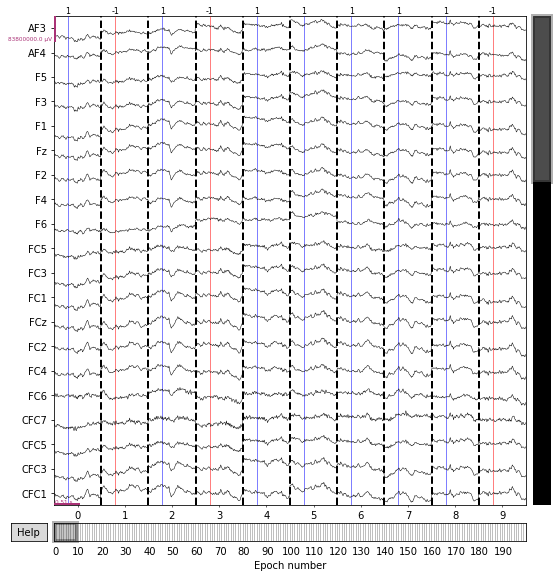

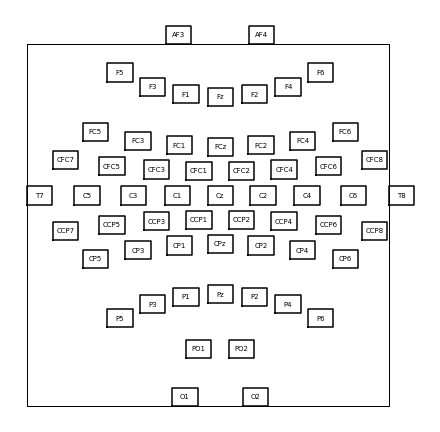

In [7]:
preprocess.plot_eeg_with_events(
    epochs=first_calib_epochs,
    n_epochs=epochs_numbers,
    events=first_events
)
preprocess.plot_layout(first_calib)

## Second File

In [8]:
second_calib = preprocess.load_matlab_file(second_file)
second_calib_epochs = preprocess.make_epochs(
    second_calib,
    tmin=t_min,
    tmax=t_max
)

Dataset has been loaded
Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


### Plotting for second File

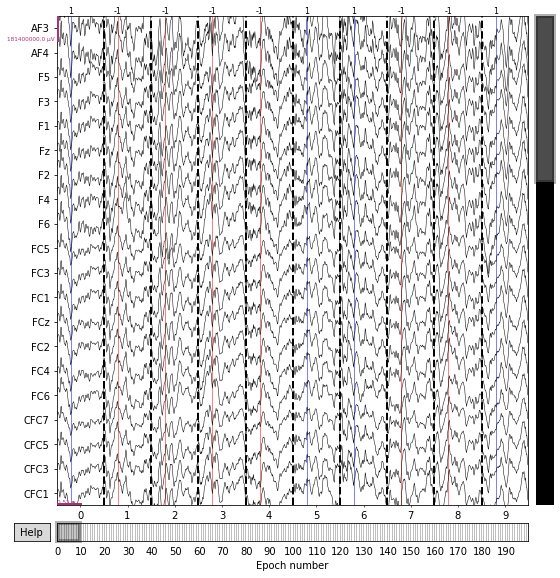

In [63]:
second_events = np.column_stack((second_calib['pos'], np.zeros_like(second_calib['pos']), second_calib['y']))
preprocess.plot_eeg_with_events(
    epochs=second_calib_epochs,
    n_epochs=epochs_numbers,
    events=second_events
)

### Simple Layout(same for all)

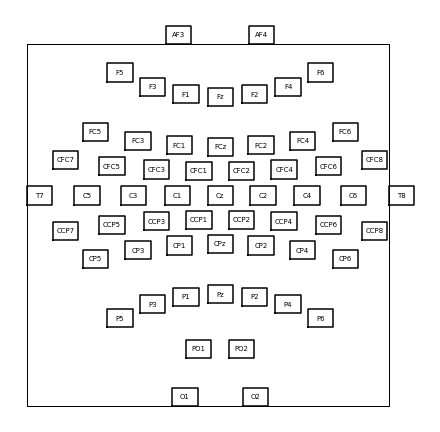

In [10]:
preprocess.plot_layout(first_calib)

## Preprocessing Starting
We will do multiple combination for preprocessing phase to see which will be better for classification and clustering
- Technique 1: band pass + CAR + Laplacian + PCA
- Technique 2: band pass + CAR + Laplacian + ICA
- Technique 3: band pass + CAR + Laplacian + CSP
- Technique 4: band pass + CAR + Small Laplacian + PCA + ICA 
- Technique 5: band pass + CAR + Small Laplacian + PCA + ICA + CSP

We will first plot for first file, after each plot to see how signals would differentiate to each other after applying filters to have intution.\
Then techniques above will applied on both files afterward

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


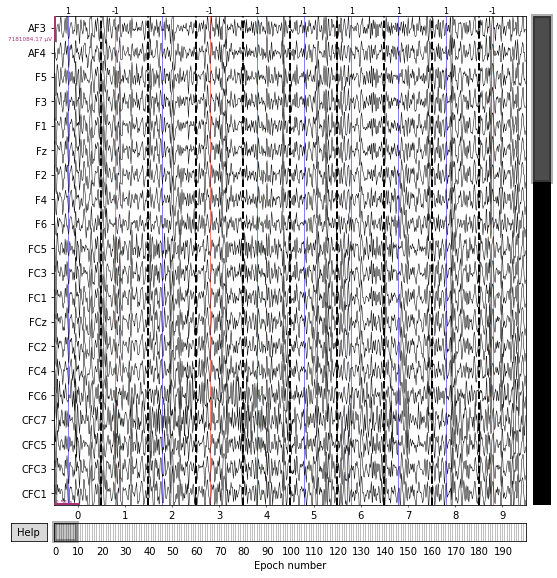

In [11]:
first_calib_preprocess = preprocess.band_pass_filter(
    first_calib,
    low_freq=8,
    high_freq=30,
    order=3,
    axis=0
)
epochs = preprocess.make_epochs(first_calib_preprocess, tmin=t_min, tmax=t_max)
preprocess.plot_eeg_with_events(epochs=epochs, n_epochs=epochs_numbers, events=first_events)

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).
Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Effective window size : 20.480 (s)


C:\Users\USER\AppData\Local\Temp\ipykernel_15744\2675277093.py:86: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(average=True, show=True)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


C:\Users\USER\AppData\Local\Temp\ipykernel_15744\2675277093.py:86: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(average=True, show=True)
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


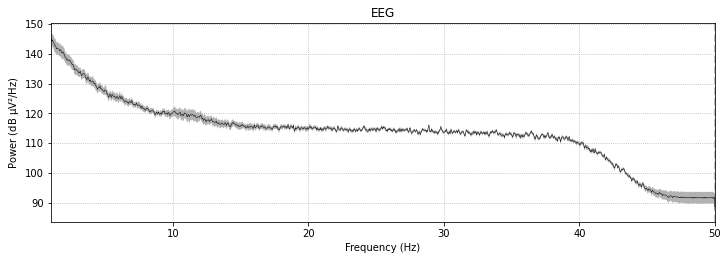

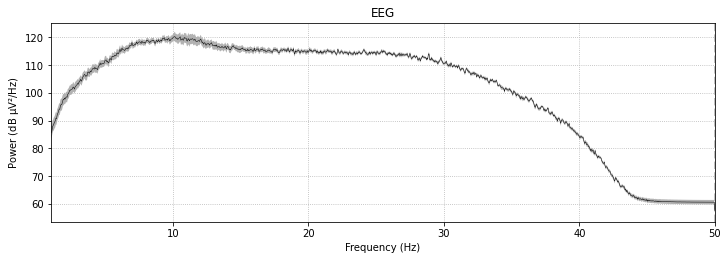

In [12]:
preprocess.plot_psd(first_calib, first_calib['sample_freq'])
preprocess.plot_psd(first_calib_preprocess, first_calib_preprocess['sample_freq'])

#### See the difference between CAR applied

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


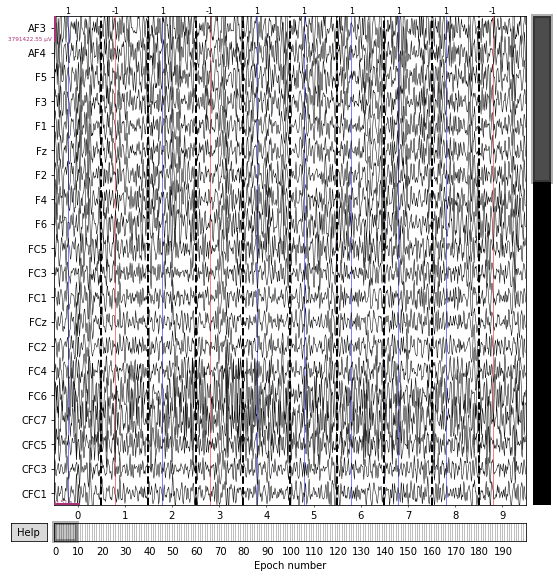

In [13]:
first_calib_preprocess = preprocess.apply_car(first_calib_preprocess)
epochs = preprocess.make_epochs(first_calib_preprocess, tmin=t_min, tmax=t_max)
preprocess.plot_eeg_with_events(epochs=epochs, n_epochs=epochs_numbers, events=first_events)

#### Applying Laplacian

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


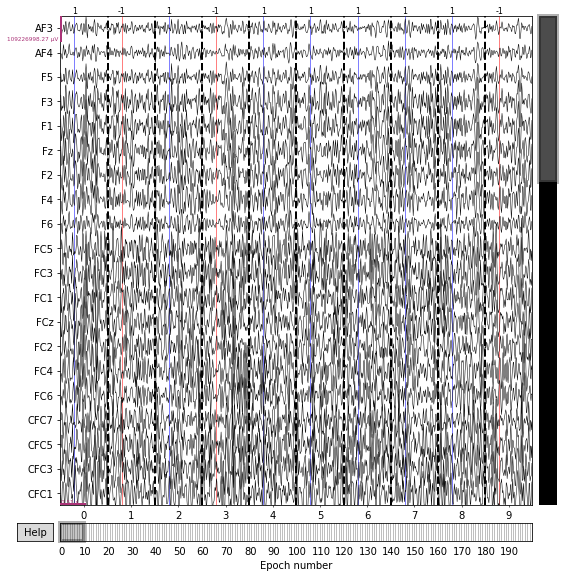

In [14]:
first_calib_preprocess = preprocess.apply_small_laplacian(first_calib_preprocess, radius=0.4)
epochs = preprocess.make_epochs(first_calib_preprocess, tmin=t_min, tmax=t_max)
preprocess.plot_eeg_with_events(epochs=epochs, n_epochs=epochs_numbers, events=first_events)

#### Applying PCA

In [15]:
print(first_calib['y'].shape)
print(epochs.get_data(copy=False).shape)

(200,)
(200, 59, 101)


Creating RawArray with float64 data, n_channels=30, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


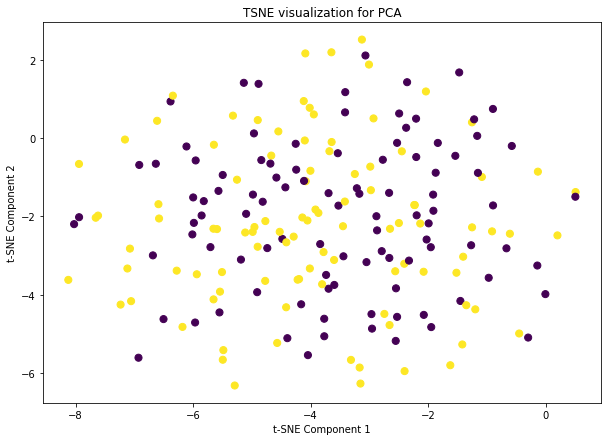

In [16]:
pca_transofrmed = preprocess.apply_PCA(n_components=30, data=first_calib_preprocess)
epochs = preprocess.make_epochs(pca_transofrmed, tmin=t_min, tmax=t_max)
preprocess.plot_tsne({'eeg_data':epochs.get_data(copy=True), 'y':epochs.events[:,-1]}, "TSNE visualization for PCA")

In [17]:
pca_transofrmed['eeg_data'].shape

(30, 190594)

#### Applyin ICA

Creating RawArray with float64 data, n_channels=30, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


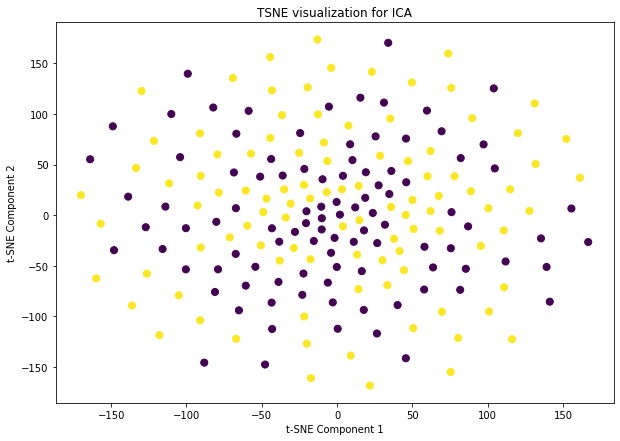

In [18]:
ica_transformed = preprocess.apply_ICA(n_components=30, data=first_calib_preprocess)
epochs = preprocess.make_epochs(ica_transformed, tmin=t_min, tmax=t_max)
preprocess.plot_tsne({'eeg_data':epochs.get_data(copy=True), 'y':epochs.events[:,-1]}, "TSNE visualization for ICA")

In [19]:
ica_transformed['eeg_data'].shape

(30, 190594)

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 4.4e+02 (2.2e-16 eps * 59 dim * 3.3e+16  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


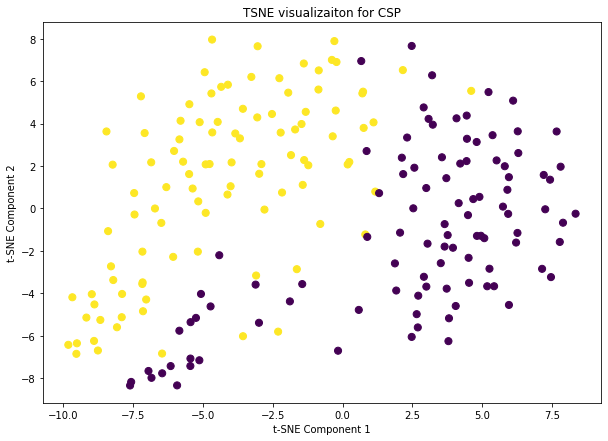

In [20]:
epochs = preprocess.make_epochs(first_calib_preprocess, tmin=t_min, tmax=t_max)
csp_transformed = preprocess.apply_CSP(epochs=epochs, n_components=40, data=first_calib)
preprocess.plot_tsne(csp_transformed, title="TSNE visualizaiton for CSP")

##  For second File

Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 41 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1e+03 (2.2e-16 eps * 59 dim * 7.7e+16  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


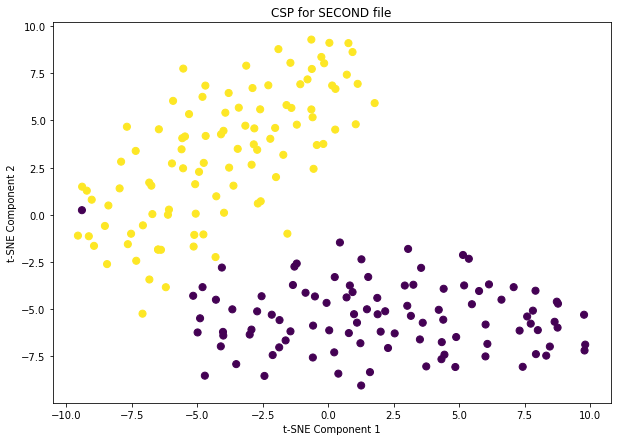

In [65]:
preprocess_second_calib = preprocess.band_pass_filter(second_calib, low_freq=8, high_freq=30, order=3)
preprocess_second_calib = preprocess.apply_car(preprocess_second_calib)
preprocess_second_calib = preprocess.apply_small_laplacian(preprocess_second_calib, radius=0.4)
second_epochs = preprocess.make_epochs(preprocess_second_calib, 0.3, 0.7)
second_technique = preprocess.apply_CSP(second_epochs, n_components=40, data=preprocess_second_calib)
preprocess.plot_tsne(second_technique, "CSP for SECOND file")

## Now we are going to apply all techniqeus that can be applied to preprocessing
We will do multiple combination for preprocessing phase to see which will be better for classification and clustering
- Technique 1: band pass + CAR + Laplacian + CSP
- Technique 2: band pass + CAR + Laplacian + PCA + CSP
- Technique 3: band pass + CAR + Laplacian + ICA + CSP
- Technique 4: band pass + CAR + Laplacian + PCA + ICA + CSP

We will do same thing on second file in each technique

In [21]:
preprocess_paramters = {
    'low_freq': 8,
    'high_freq': 30,
    'order':3,
    'radius':0.4,
    'tmin':-0.3,
    'tmax':0.7
}

#### Technique 1

In [22]:
preprocess_first_calib_t1 = preprocess.band_pass_filter(first_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_first_calib_t1 = preprocess.apply_car(preprocess_first_calib_t1)
preprocess_first_calib_t1 = preprocess.apply_small_laplacian(preprocess_first_calib_t1, radius=preprocess_paramters['radius'])
first_epochs_t1 = preprocess.make_epochs(preprocess_first_calib_t1, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
first_technique_1 = preprocess.apply_CSP(first_epochs_t1, n_components=40, data=preprocess_first_calib_t1)


### Second File also
preprocess_second_calib_t1 = preprocess.band_pass_filter(second_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_second_calib_t1 = preprocess.apply_car(preprocess_second_calib_t1)
preprocess_second_calib_t1 = preprocess.apply_small_laplacian(preprocess_second_calib_t1, radius=preprocess_paramters['radius'])
second_epochs_t1 = preprocess.make_epochs(preprocess_second_calib_t1, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
second_technique_1 = preprocess.apply_CSP(second_epochs_t1, n_components=40, data=preprocess_second_calib_t1)

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 4.4e+02 (2.2e-16 eps * 59 dim * 3.3e+16  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data f

### Technique 2

In [23]:
preprocess_first_calib_t2 = preprocess.band_pass_filter(first_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_first_calib_t2 = preprocess.apply_car(preprocess_first_calib_t2)
preprocess_first_calib_t2 = preprocess.apply_small_laplacian(preprocess_first_calib_t2, radius=preprocess_paramters['radius'])
preprocess_first_calib_t2 = preprocess.apply_PCA(n_components=40, data=preprocess_first_calib_t2)
first_epochs_t2 = preprocess.make_epochs(preprocess_first_calib_t2, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
first_technique_2 = preprocess.apply_CSP(first_epochs_t2, n_components=20, data=preprocess_first_calib_t2)


### Second File also
preprocess_second_calib_t2 = preprocess.band_pass_filter(second_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_second_calib_t2 = preprocess.apply_car(preprocess_second_calib_t2)
preprocess_second_calib_t2 = preprocess.apply_small_laplacian(preprocess_second_calib_t2, radius=preprocess_paramters['radius'])
preprocess_second_calib_t2 = preprocess.apply_PCA(n_components=40, data=preprocess_second_calib_t2)
second_epochs_t2 = preprocess.make_epochs(preprocess_second_calib_t2, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
second_technique_2 = preprocess.apply_CSP(second_epochs_t2, n_components=20, data=preprocess_second_calib_t2)

Creating RawArray with float64 data, n_channels=40, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3e+02 (2.2e-16 eps * 40 dim * 3.3e+16  max singular value)
    Estimated rank (data): 40
    data: rank 40 computed from 40 data channels with 0 projectors
Reducing data rank from 40 -> 40
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Creating RawArray with float64 data, n_channels=40, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time poin

### Technique 3

In [24]:
preprocess_first_calib_t3 = preprocess.band_pass_filter(first_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_first_calib_t3 = preprocess.apply_car(preprocess_first_calib_t3)
preprocess_first_calib_t3 = preprocess.apply_small_laplacian(preprocess_first_calib_t3, radius=preprocess_paramters['radius'])
preprocess_first_calib_t3 = preprocess.apply_ICA(n_components=40, data=preprocess_first_calib_t3)
first_epochs_t3 = preprocess.make_epochs(preprocess_first_calib_t3, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
first_technique_3 = preprocess.apply_CSP(first_epochs_t3, n_components=20, data=preprocess_first_calib_t3)


### Second File also
preprocess_second_calib_t3 = preprocess.band_pass_filter(second_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_second_calib_t3 = preprocess.apply_car(preprocess_second_calib_t3)
preprocess_second_calib_t3 = preprocess.apply_small_laplacian(preprocess_second_calib_t3, radius=preprocess_paramters['radius'])
preprocess_second_calib_t3 = preprocess.apply_ICA(n_components=40, data=preprocess_second_calib_t3)
second_epochs_t3 = preprocess.make_epochs(preprocess_second_calib_t3, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
second_technique_3 = preprocess.apply_CSP(second_epochs_t3, n_components=20, data=preprocess_second_calib_t3)

Creating RawArray with float64 data, n_channels=40, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 40 dim * 3.5e+11  max singular value)
    Estimated rank (data): 40
    data: rank 40 computed from 40 data channels with 0 projectors
Reducing data rank from 40 -> 40
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Creating RawArray with float64 data, n_channels=40, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time poi

### Technique 4

In [25]:
preprocess_first_calib_t4 = preprocess.band_pass_filter(first_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_first_calib_t4 = preprocess.apply_car(preprocess_first_calib_t4)
preprocess_first_calib_t4 = preprocess.apply_small_laplacian(preprocess_first_calib_t4, radius=preprocess_paramters['radius'])
preprocess_first_calib_t4 = preprocess.apply_PCA(n_components=40, data=preprocess_first_calib_t4)
preprocess_first_calib_t4 = preprocess.apply_ICA(n_components=20, data=preprocess_first_calib_t4)
first_epochs_t4 = preprocess.make_epochs(preprocess_first_calib_t4, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
first_technique_4 = preprocess.apply_CSP(first_epochs_t4, n_components=10, data=preprocess_first_calib_t4)


### Second File also
preprocess_second_calib_t4 = preprocess.band_pass_filter(second_calib, low_freq=preprocess_paramters['low_freq'], high_freq=preprocess_paramters['high_freq'], order=preprocess_paramters['order'])
preprocess_second_calib_t4 = preprocess.apply_car(preprocess_second_calib_t4)
preprocess_second_calib_t4 = preprocess.apply_small_laplacian(preprocess_second_calib_t4, radius=preprocess_paramters['radius'])
preprocess_second_calib_t4 = preprocess.apply_PCA(n_components=40, data=preprocess_second_calib_t4)
preprocess_second_calib_t4 = preprocess.apply_ICA(n_components=20, data=preprocess_second_calib_t4)
second_epochs_t4 = preprocess.make_epochs(preprocess_second_calib_t4, preprocess_paramters['tmin'], preprocess_paramters['tmax'])
second_technique_4 = preprocess.apply_CSP(second_epochs_t4, n_components=10, data=preprocess_second_calib_t4)

Creating RawArray with float64 data, n_channels=20, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.0015 (2.2e-16 eps * 20 dim * 3.5e+11  max singular value)
    Estimated rank (data): 20
    data: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Creating RawArray with float64 data, n_channels=20, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 101 original time poi

# Classification class
-   SVM(Grid search for different paramters)
-   MLP using torch
-   KNN classifier

In [26]:
class my_clf(object):
    def __init__(self) -> None:
        print("object created successfully")
    
    def split_data(self, X:np.arange, y:np.array, test_size:float=0.25, random_state:int=42) -> tuple:
        """
        Splittting dataset to train and test
        """
        X = copy.deepcopy(X)
        y = copy.deepcopy(y)
        X = X.reshape(X.shape[0], -1)
        return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    
    def SVM(self, X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array, param_grid:dict, cv:int=5) -> None:
        grid_search = GridSearchCV(SVC(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print("-------------------------------")
        print(f'The best parameters are:\n {grid_search.best_params_}')
        y_pred = best_model.predict(X_test)
        y_score = best_model.decision_function(X_test)
        print("-------------------------------")
        print('classification report:')
        print(self._classification_report(y_test, y_pred))
        print("-------------------------------")
        print("Confusion matrix:")
        print(self._confusion_matrix(y_test, y_pred))
        print("-------------------------------")
        self._plot_roc_curve(y_test=y_test, y_pred_proba=y_score)
    
    def KNN(self, X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array, param_grid:dict, cv:int=5) -> None:
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f'The best parameters are:\n {grid_search.best_params_}')
        y_pred = best_model.predict(X_test)
        y_score = best_model.predict_proba(X_test)
        print("-------------------------------")
        print('classification report:')
        print(self._classification_report(y_test, y_pred))
        print("-------------------------------")
        print("Confusion matrix:")
        print(self._confusion_matrix(y_test, y_pred))
        print("-------------------------------")
        self._plot_roc_curve(y_test=y_test, y_pred_proba=y_score[:, 1])

    def LogReg(self, X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array, param_grid:dict, cv:int=5) -> None:
        y_train_1 = np.copy(y_train)
        y_test_1 = np.copy(y_test)
        y_train_1 = (y_train_1 == 1).astype(int)
        y_test_1 = (y_test_1 == 1).astype(int) 
        grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train_1)
        best_model = grid_search.best_estimator_
        print(f'The best parameters are:\n {grid_search.best_params_}')
        y_pred = best_model.predict(X_test)
        y_score = best_model.predict_proba(X_test)
        print("-------------------------------")
        print('classification report:')
        print(self._classification_report(y_test_1, y_pred))
        print("-------------------------------")
        print("Confusion matrix:")
        print(self._confusion_matrix(y_test_1, y_pred))
        print("-------------------------------")
        self._plot_roc_curve(y_test=y_test_1, y_pred_proba=y_score[:, 1])


    def _classification_report(self, y_test:np.array, y_pred:np.array) -> dict:
        return classification_report(y_test, y_pred)
    
    def _confusion_matrix(self, y_test:np.array, y_pred:np.array) -> dict:
        return confusion_matrix(y_test, y_pred)
    
    def _plot_roc_curve(self, y_test:np.array, y_pred_proba:np.array) -> None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
        roc_auc = auc(fpr, tpr)
        plt.figure()  
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

## SVM parameters defined

In [27]:
C_range = [0.1, 1, 10, 100, 1000]

svm_grid = [
    {'kernel': ['linear'], 'C': C_range},
    {'kernel': ['poly'], 'C': C_range, 'degree': [2, 3, 4], 'gamma': ['scale', 'auto']},
    {'kernel': ['rbf'], 'C': C_range, 'gamma': ['scale', 'auto']},
]

knn_grid = {
    'n_neighbors': [i+1 for i in range(20)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

log_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear'] 
}

### For technique 1

In [28]:
svm = my_clf()
knn = my_clf()
lgreg = my_clf()

object created successfully
object created successfully
object created successfully


Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 1, 'kernel': 'linear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.83      1.00      0.91        25
           1       1.00      0.80      0.89        25

    accuracy                           0.90        50
   macro avg       0.92      0.90      0.90        50
weighted avg       0.92      0.90      0.90        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 5 20]]
-------------------------------


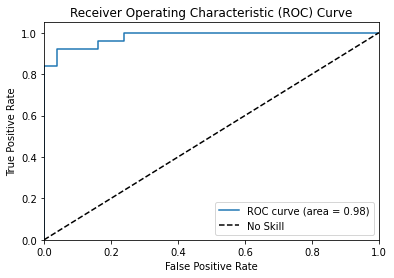

In [29]:
X_train, X_test, y_train, y_test = svm.split_data(first_technique_1['eeg_data'], first_technique_1['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93        25
           1       1.00      0.84      0.91        25

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.93      0.92      0.92        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 4 21]]
-------------------------------


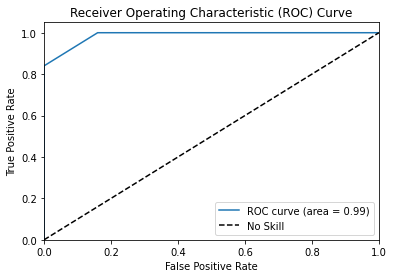

In [30]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.95      0.84      0.89        25

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50

-------------------------------
Confusion matrix:
[[24  1]
 [ 4 21]]
-------------------------------


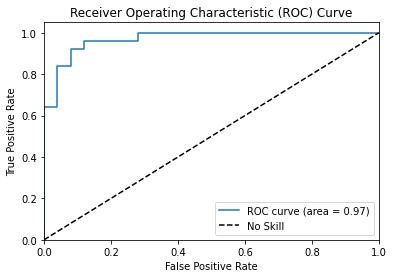

In [31]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

##### Secnod File

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 0.1, 'kernel': 'linear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 0 25]]
-------------------------------


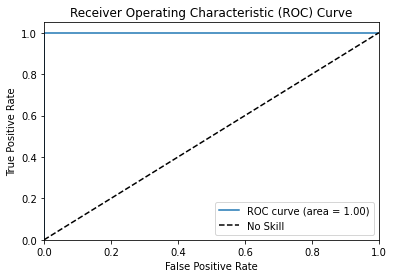

In [32]:
X_train, X_test, y_train, y_test = svm.split_data(second_technique_1['eeg_data'], second_technique_1['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 0 25]]
-------------------------------


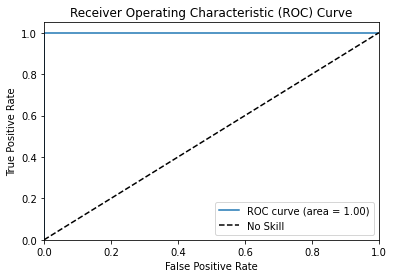

In [33]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

-------------------------------
Confusion matrix:
[[24  1]
 [ 0 25]]
-------------------------------


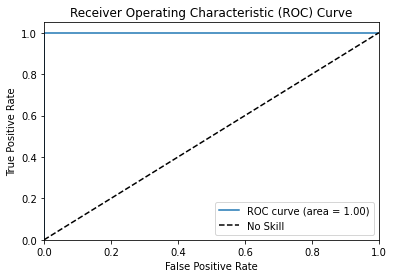

In [34]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

### For technique 2

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

-------------------------------
Confusion matrix:
[[23  2]
 [ 3 22]]
-------------------------------


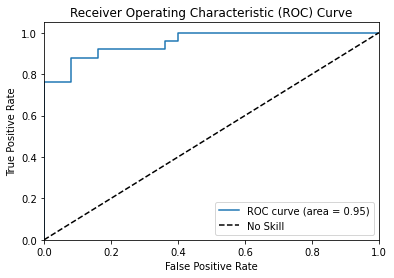

In [35]:
X_train, X_test, y_train, y_test = svm.split_data(first_technique_2['eeg_data'], first_technique_2['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.86      0.76      0.81        25
           1       0.79      0.88      0.83        25

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82      0.82      0.82        50

-------------------------------
Confusion matrix:
[[19  6]
 [ 3 22]]
-------------------------------


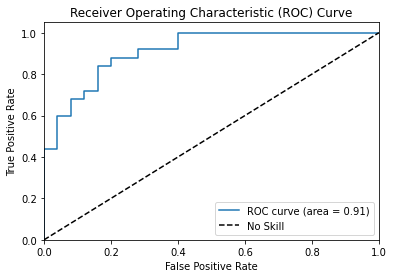

In [36]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        25
           1       0.87      0.80      0.83        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

-------------------------------
Confusion matrix:
[[22  3]
 [ 5 20]]
-------------------------------


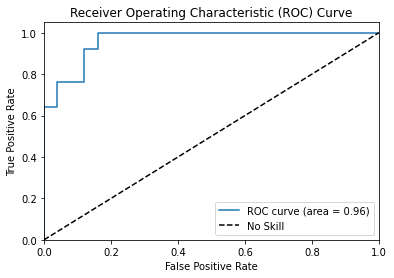

In [37]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

##### Secnod File

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 3 22]]
-------------------------------


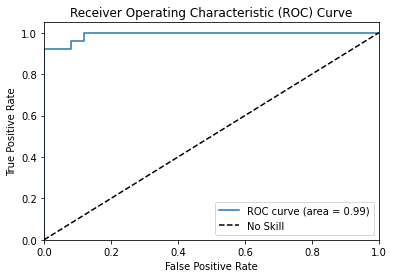

In [38]:
X_train, X_test, y_train, y_test = svm.split_data(second_technique_2['eeg_data'], second_technique_2['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.88      0.88      0.88        25
           1       0.88      0.88      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

-------------------------------
Confusion matrix:
[[22  3]
 [ 3 22]]
-------------------------------


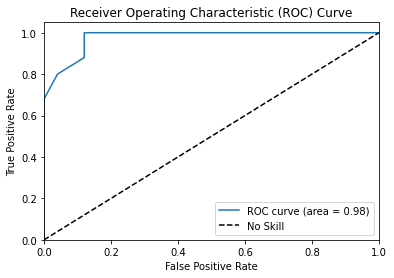

In [39]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 3 22]]
-------------------------------


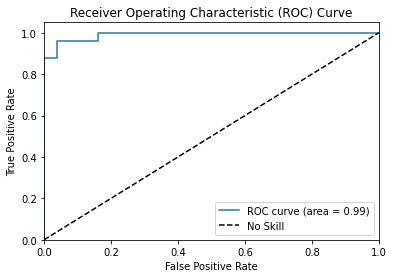

In [40]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

## For technique 3

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

-------------------------------
Confusion matrix:
[[23  2]
 [ 3 22]]
-------------------------------


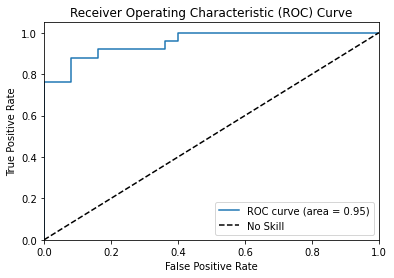

In [41]:
X_train, X_test, y_train, y_test = svm.split_data(first_technique_3['eeg_data'], first_technique_3['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.79      0.76      0.78        25
           1       0.77      0.80      0.78        25

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50

-------------------------------
Confusion matrix:
[[19  6]
 [ 5 20]]
-------------------------------


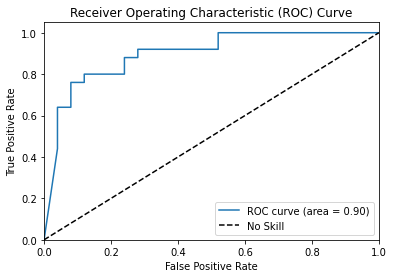

In [42]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        25
           1       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

-------------------------------
Confusion matrix:
[[22  3]
 [ 4 21]]
-------------------------------


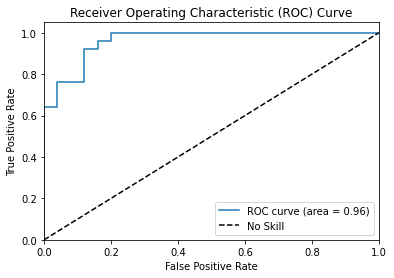

In [43]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

##### Secnod File

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 3 22]]
-------------------------------


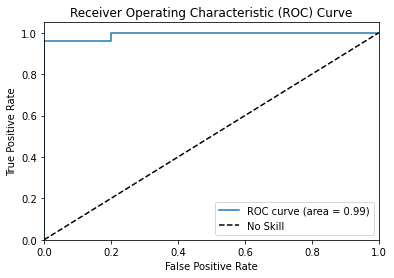

In [44]:
X_train, X_test, y_train, y_test = svm.split_data(second_technique_3['eeg_data'], second_technique_3['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 3 22]]
-------------------------------


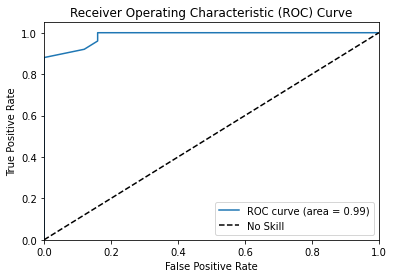

In [45]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

-------------------------------
Confusion matrix:
[[25  0]
 [ 3 22]]
-------------------------------


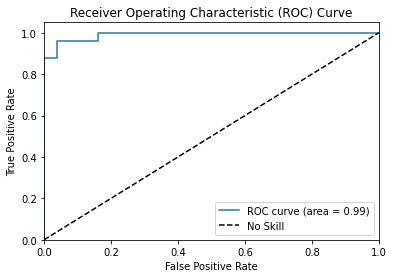

In [46]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

## For technique 4

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.64      0.56      0.60        25
           1       0.61      0.68      0.64        25

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.62      0.62      0.62        50

-------------------------------
Confusion matrix:
[[14 11]
 [ 8 17]]
-------------------------------


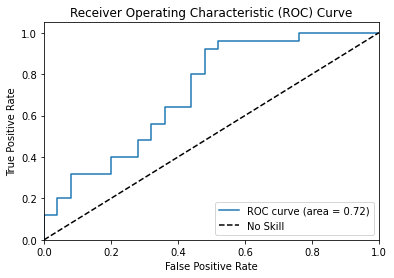

In [47]:
X_train, X_test, y_train, y_test = svm.split_data(first_technique_4['eeg_data'], first_technique_4['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.71      0.68      0.69        25
           1       0.69      0.72      0.71        25

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50

-------------------------------
Confusion matrix:
[[17  8]
 [ 7 18]]
-------------------------------


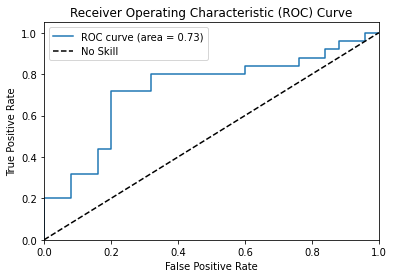

In [48]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60        25
           1       0.59      0.52      0.55        25

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.58      0.58      0.58        50

-------------------------------
Confusion matrix:
[[16  9]
 [12 13]]
-------------------------------


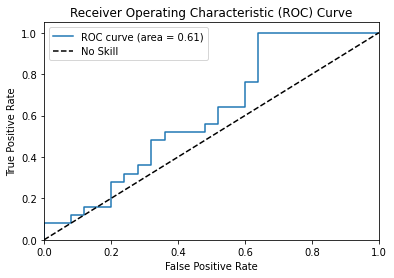

In [49]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

##### Secnod File

Fitting 5 folds for each of 45 candidates, totalling 225 fits
-------------------------------
The best parameters are:
 {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.73      0.88      0.80        25
           1       0.85      0.68      0.76        25

    accuracy                           0.78        50
   macro avg       0.79      0.78      0.78        50
weighted avg       0.79      0.78      0.78        50

-------------------------------
Confusion matrix:
[[22  3]
 [ 8 17]]
-------------------------------


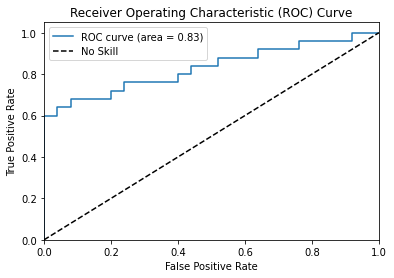

In [50]:
X_train, X_test, y_train, y_test = svm.split_data(second_technique_4['eeg_data'], second_technique_4['y'], test_size=0.25, random_state=42)
svm.SVM(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=svm_grid, cv=5)

The best parameters are:
 {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
-------------------------------
classification report:
              precision    recall  f1-score   support

          -1       0.65      0.80      0.71        25
           1       0.74      0.56      0.64        25

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.68        50
weighted avg       0.69      0.68      0.68        50

-------------------------------
Confusion matrix:
[[20  5]
 [11 14]]
-------------------------------


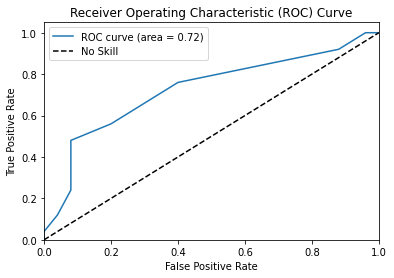

In [51]:
knn.KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=knn_grid, cv=5)

The best parameters are:
 {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
-------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82        25
           1       0.89      0.68      0.77        25

    accuracy                           0.80        50
   macro avg       0.82      0.80      0.80        50
weighted avg       0.82      0.80      0.80        50

-------------------------------
Confusion matrix:
[[23  2]
 [ 8 17]]
-------------------------------


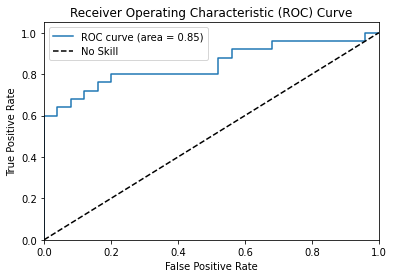

In [52]:
lgreg.LogReg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, param_grid=log_grid, cv=5)

# Clustering
-   Kmeans
-   agglomerative

For this purporse we will create another class

In [53]:
class clustering(object):
    def __init__(self) -> None:
        print("object was successfully created!")
    
    def apply_kmeans(self, X:np.array, y:np.array, random_state:int=42) -> None:
        ce = clusteval(cluster='kmeans', evaluate='silhouette')
        results = ce.fit(X)
        top_3_scores = results['score'].nlargest(3, 'score') 
        top_3_clusters = top_3_scores['clusters'].values   
        print("-------------------------------")
        print("Top 3 scores:")
        print(top_3_scores)
        print("-------------------------------")
        print("Number of clusters for the top 3 scores:", top_3_clusters)
        top_3_models = []
        for n_clusters in top_3_clusters:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            kmeans.fit(X)
            top_3_models.append(kmeans)
        for i, model in enumerate(top_3_models):
            labels = model.labels_
            purity = self._calculate_purity(y, labels)
            print(f"Purity for model {i+1} with {top_3_clusters[i]} clusters: {purity:.4f}")
        self._plot_clusters(top_3_models=top_3_models, X=X, top_scores=top_3_scores, top_clusters=top_3_clusters, kind="K-means")

    def apply_agglomerative(self, X:np.array, y:np.array) -> None:
        ce = clusteval(cluster='agglomerative', evaluate='silhouette')
        results = ce.fit(X)
        top_3_scores = results['score'].nlargest(3, 'score') 
        top_3_clusters = top_3_scores['clusters'].values   
        print("-------------------------------")
        print("Top 3 scores:")
        print(top_3_scores)
        print("-------------------------------")
        print("Number of clusters for the top 3 scores:", top_3_clusters)
        top_3_models = []
        for n_clusters in top_3_clusters:
            aggle = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
            aggle.fit(X)
            top_3_models.append(aggle)
        for i, model in enumerate(top_3_models):
            labels = model.labels_
            purity = self._calculate_purity(y, labels)
            print(f"Purity for model {i+1} with {top_3_clusters[i]} clusters: {purity:.4f}")
        self._plot_clusters(top_3_models=top_3_models, X=X, top_scores=top_3_scores, top_clusters=top_3_clusters, kind="Agglomerative")

    def _calculate_purity(self, y_true:np.array, y_pred:np.array) -> float:
        contingency_matrix = confusion_matrix(y_true, y_pred)
        return np.sum(np.max(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

    def _plot_clusters(self, top_3_models:list, X:np.array, top_scores:list[float], top_clusters:list[int], kind:str) -> None:
        tsne = TSNE(n_components=2, random_state=42, init='random')
        X_tsne = tsne.fit_transform(X)
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))

        for i, model in enumerate(top_3_models):
            labels = model.labels_
            
            axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=50, cmap='viridis')
            axes[i].set_title(f'{kind} with {top_clusters[i]} clusters\nSilhouette Score: {top_scores["score"].iloc[i]:.4f}')
            axes[i].set_xlabel('t-SNE Component 1')
            axes[i].set_ylabel('t-SNE Component 2')
        
        plt.tight_layout()
        plt.show()

In [54]:
my_cluster = clustering()

object was successfully created!


## Technique 1

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 15.16it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.306664
1                  3         3  0.133671
2                  4         4  0.120384
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5450
Purity for model 2 with 3 clusters: 0.8950
Purity for model 3 with 4 clusters: 0.8850


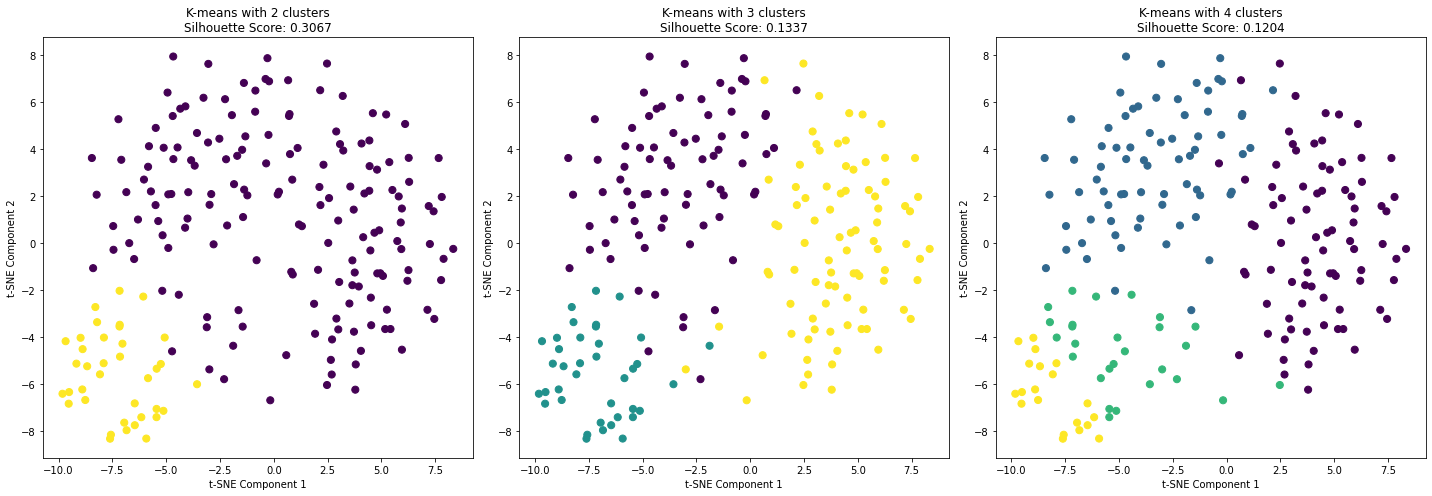

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 459.30it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.317188
1                  3         3  0.110794
3                  5         5  0.105235
-------------------------------
Number of clusters for the top 3 scores: [2 3 5]
Purity for model 1 with 2 clusters: 0.5600
Purity for model 2 with 3 clusters: 0.8700
Purity for model 3 with 5 clusters: 0.9150


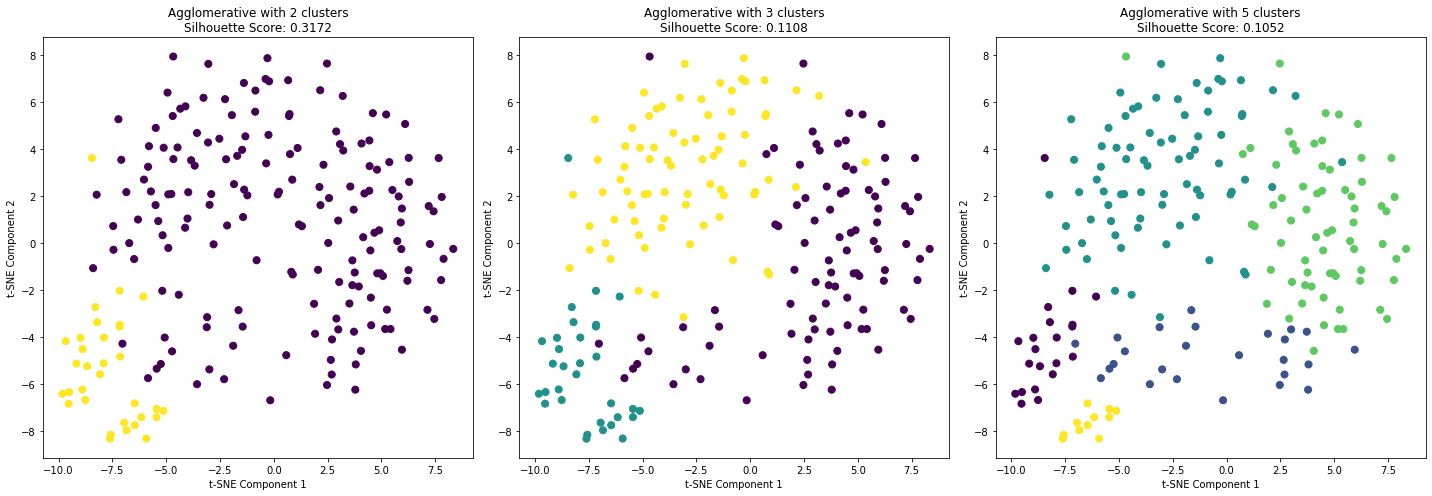

In [55]:
my_cluster.apply_kmeans(X=first_technique_1['eeg_data'], y=first_technique_1['y'])
my_cluster.apply_agglomerative(X=first_technique_1['eeg_data'], y=first_technique_1['y'])

##### Secnod File

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 16.59it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.170312
1                  3         3  0.139833
2                  4         4  0.103690
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5900
Purity for model 2 with 3 clusters: 0.7800
Purity for model 3 with 4 clusters: 0.9900


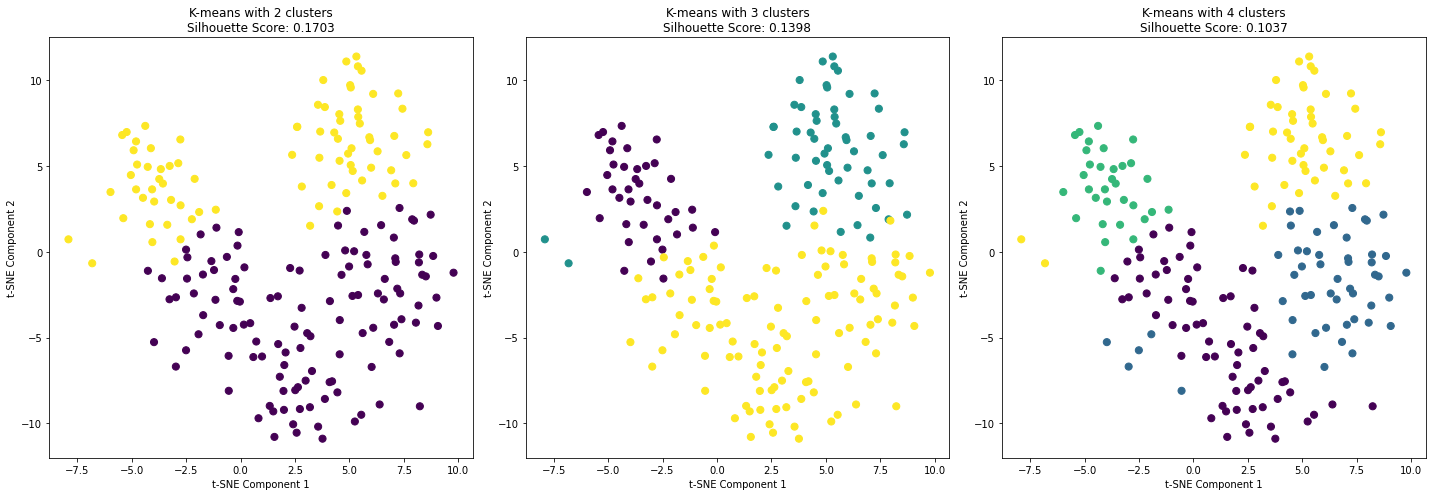

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 599.92it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.159331
1                  3         3  0.145683
2                  4         4  0.091136
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.6350
Purity for model 2 with 3 clusters: 0.7650
Purity for model 3 with 4 clusters: 0.9750


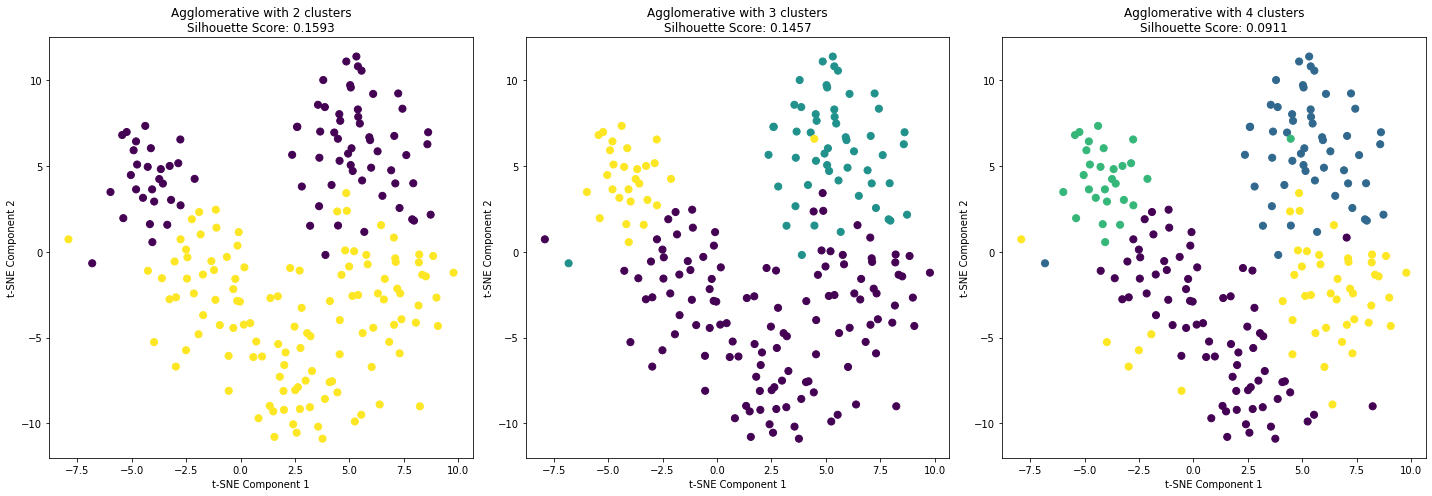

In [56]:
my_cluster.apply_kmeans(X=second_technique_1['eeg_data'], y=second_technique_1['y'])
my_cluster.apply_agglomerative(X=second_technique_1['eeg_data'], y=second_technique_1['y'])

## Technique 2

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 13.07it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.357820
1                  3         3  0.203041
2                  4         4  0.129070
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5300
Purity for model 2 with 3 clusters: 0.6650
Purity for model 3 with 4 clusters: 0.6650


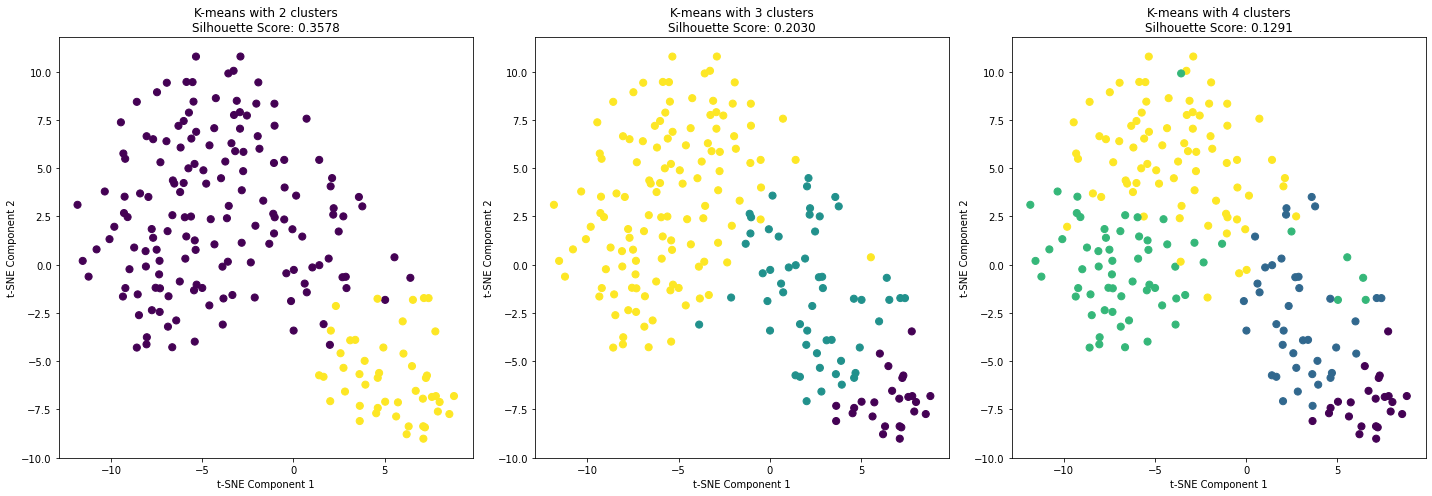

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 546.87it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.352666
1                  3         3  0.123386
2                  4         4  0.120523
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5150
Purity for model 2 with 3 clusters: 0.6550
Purity for model 3 with 4 clusters: 0.6600


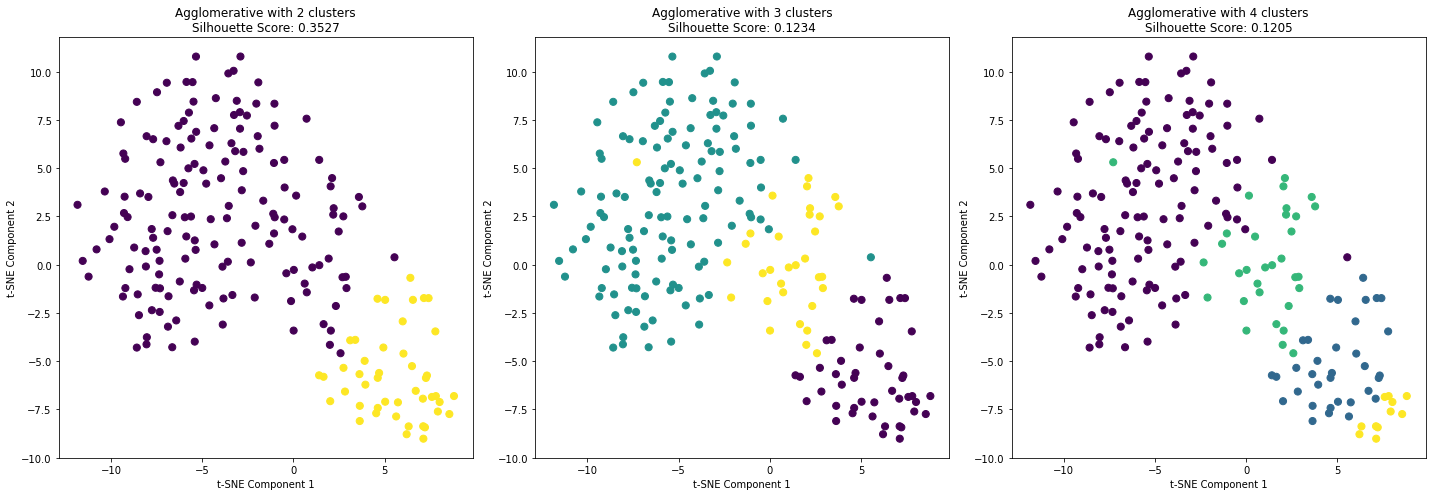

In [57]:
my_cluster.apply_kmeans(X=first_technique_2['eeg_data'], y=first_technique_2['y'])
my_cluster.apply_agglomerative(X=first_technique_2['eeg_data'], y=first_technique_2['y'])

##### Secnod File

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 13.87it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.152279
1                  3         3  0.107912
2                  4         4  0.102134
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5650
Purity for model 2 with 3 clusters: 0.8000
Purity for model 3 with 4 clusters: 0.9450


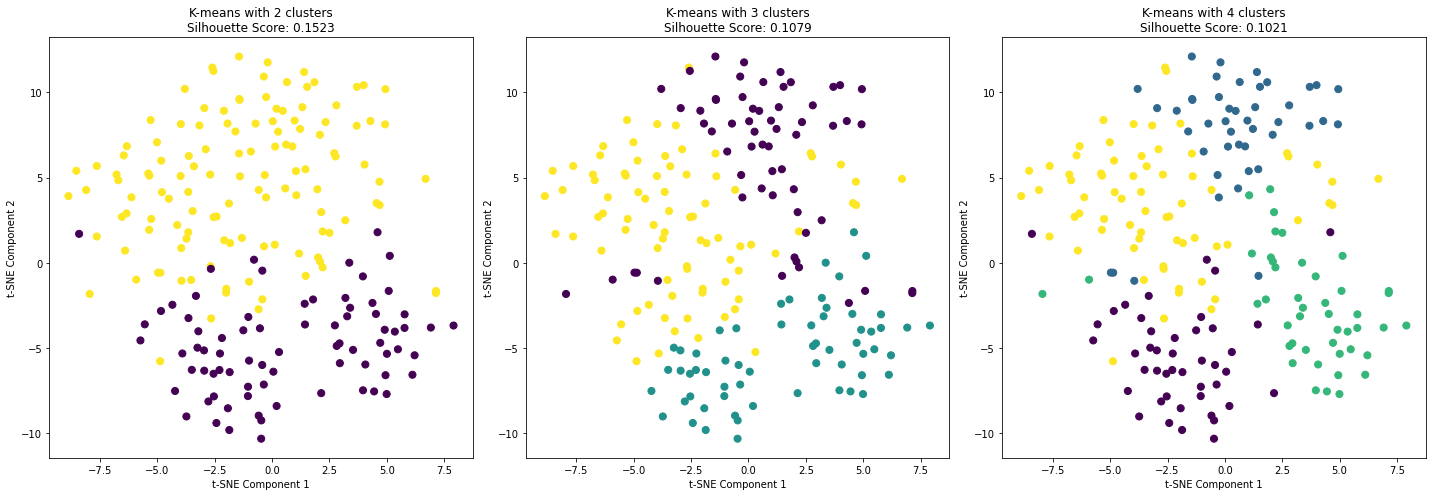

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 107.88it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.153808
2                  4         4  0.088618
1                  3         3  0.086681
-------------------------------
Number of clusters for the top 3 scores: [2 4 3]
Purity for model 1 with 2 clusters: 0.5250
Purity for model 2 with 4 clusters: 0.8900
Purity for model 3 with 3 clusters: 0.7550


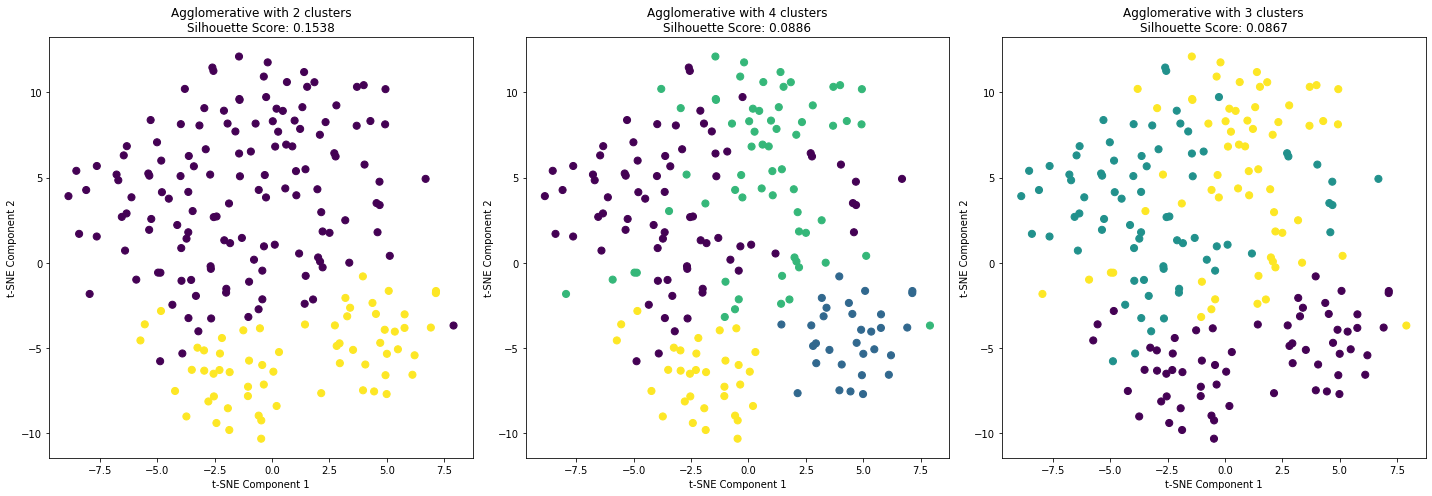

In [58]:
my_cluster.apply_kmeans(X=second_technique_2['eeg_data'], y=second_technique_2['y'])
my_cluster.apply_agglomerative(X=second_technique_2['eeg_data'], y=second_technique_2['y'])

## Technique 3

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 14.67it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.355285
1                  3         3  0.193808
2                  4         4  0.129808
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5300
Purity for model 2 with 3 clusters: 0.6650
Purity for model 3 with 4 clusters: 0.6650


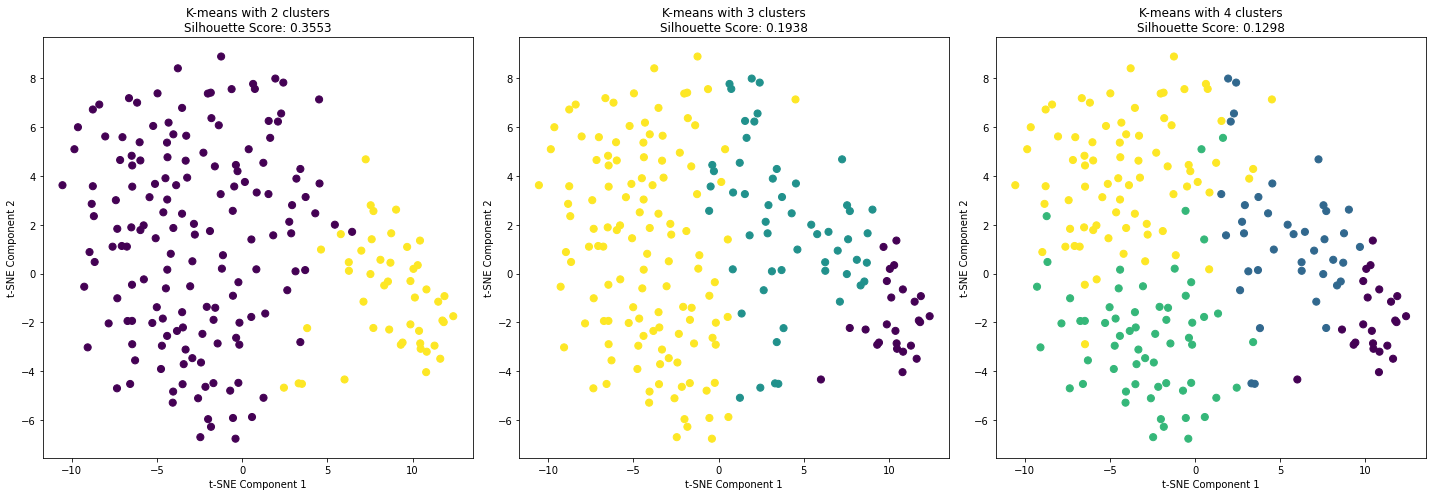

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 537.72it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.366803
1                  3         3  0.173844
2                  4         4  0.098282
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5050
Purity for model 2 with 3 clusters: 0.6300
Purity for model 3 with 4 clusters: 0.6550


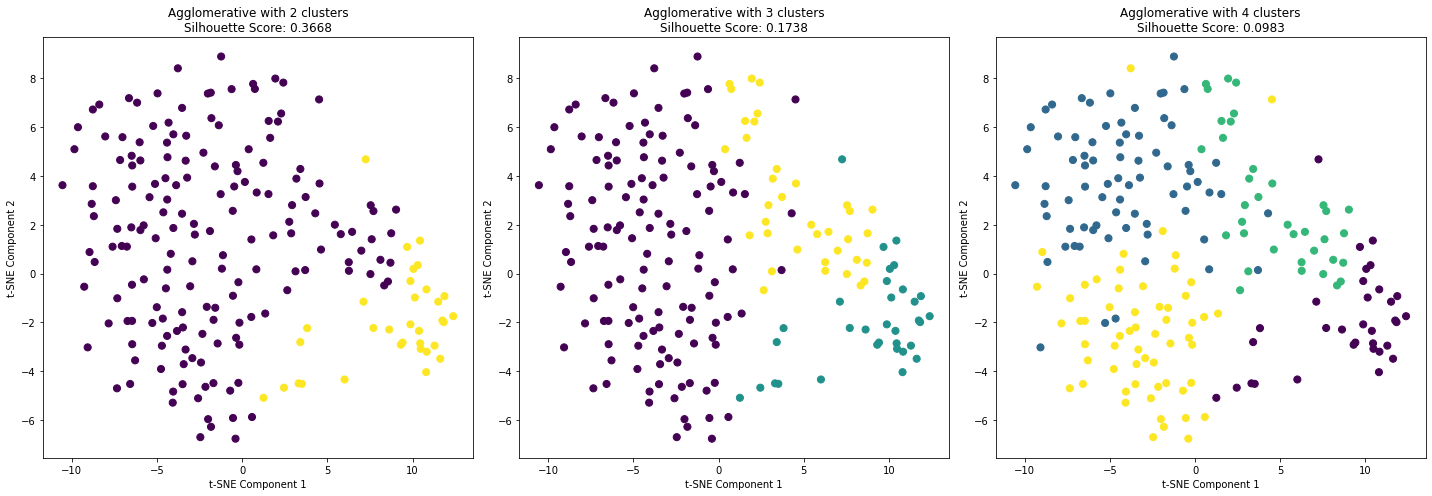

In [59]:
my_cluster.apply_kmeans(X=first_technique_3['eeg_data'], y=first_technique_3['y'])
my_cluster.apply_agglomerative(X=first_technique_3['eeg_data'], y=first_technique_3['y'])

##### Secnod File

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 14.05it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.152395
1                  3         3  0.108093
2                  4         4  0.103458
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5650
Purity for model 2 with 3 clusters: 0.8000
Purity for model 3 with 4 clusters: 0.9350


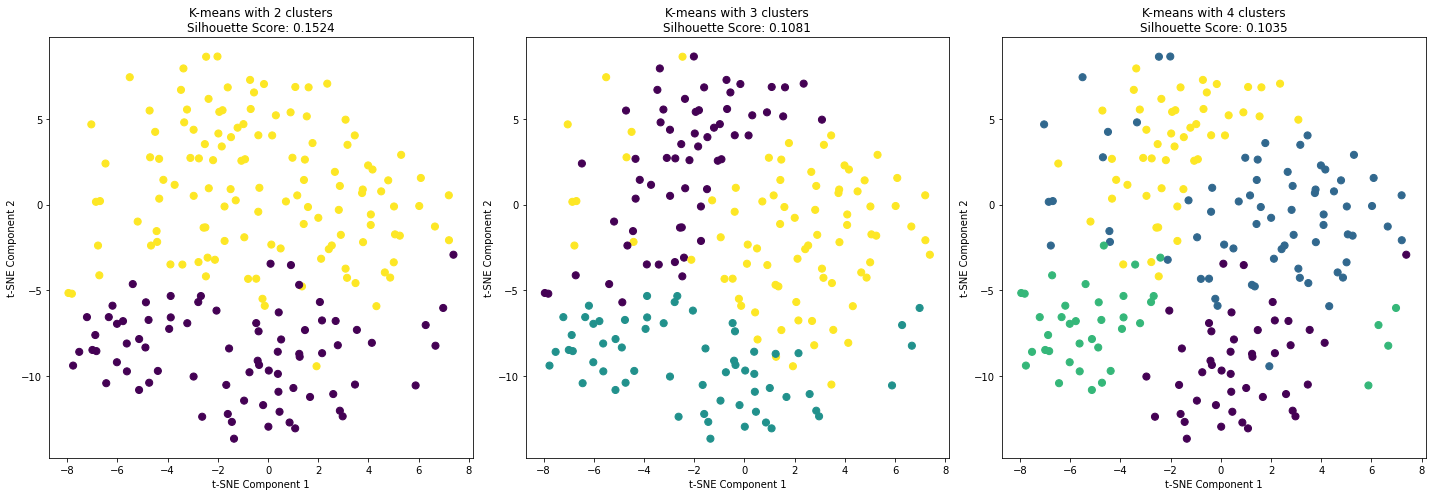

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 428.90it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.101453
1                  3         3  0.093742
2                  4         4  0.075607
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5850
Purity for model 2 with 3 clusters: 0.8650
Purity for model 3 with 4 clusters: 0.8650


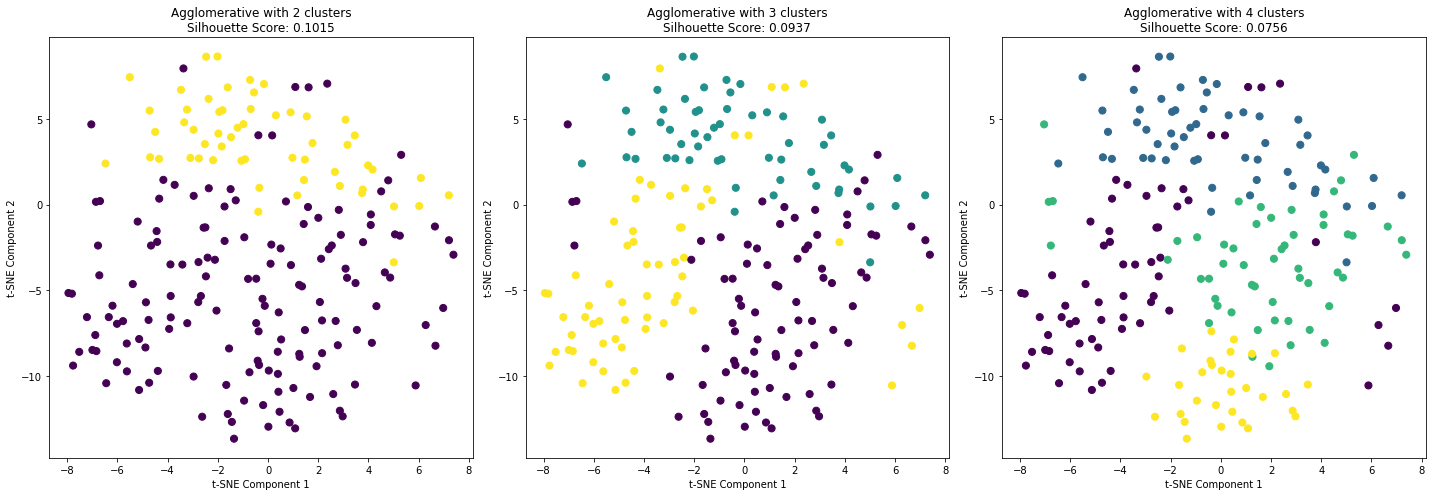

In [60]:
my_cluster.apply_kmeans(X=second_technique_3['eeg_data'], y=second_technique_3['y'])
my_cluster.apply_agglomerative(X=second_technique_3['eeg_data'], y=second_technique_3['y'])

## Technique 4

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 14.87it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.472775
1                  3         3  0.229707
2                  4         4  0.226456
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5300
Purity for model 2 with 3 clusters: 0.5200
Purity for model 3 with 4 clusters: 0.5550


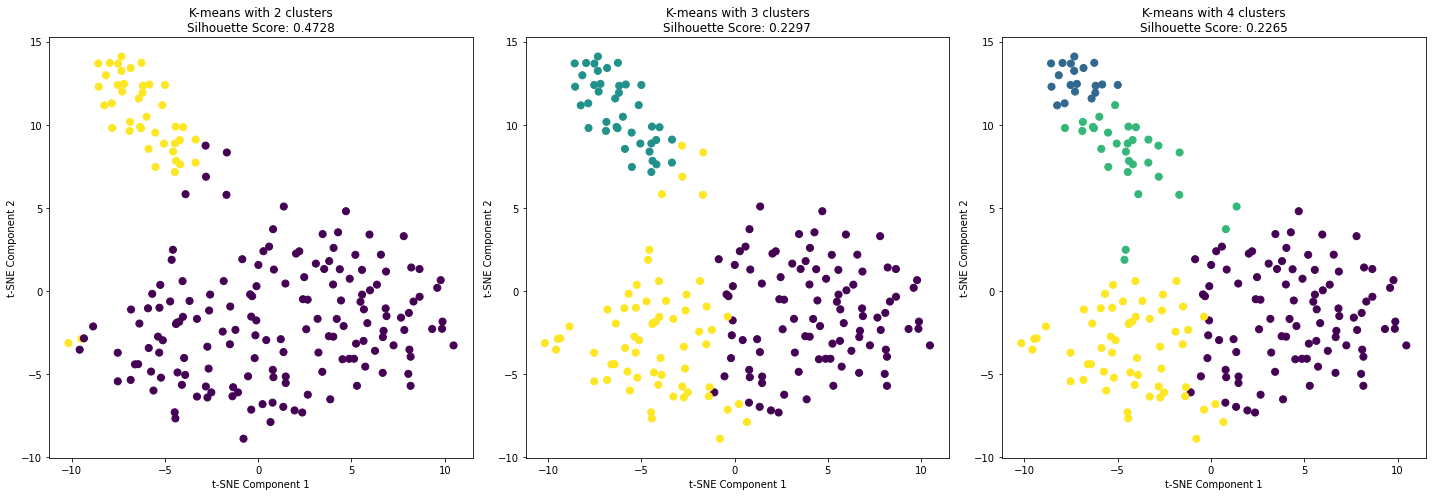

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 165.47it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
   cluster_threshold  clusters     score
0                  2         2  0.459180
1                  3         3  0.216912
2                  4         4  0.198404
-------------------------------
Number of clusters for the top 3 scores: [2 3 4]
Purity for model 1 with 2 clusters: 0.5350
Purity for model 2 with 3 clusters: 0.5400
Purity for model 3 with 4 clusters: 0.5400


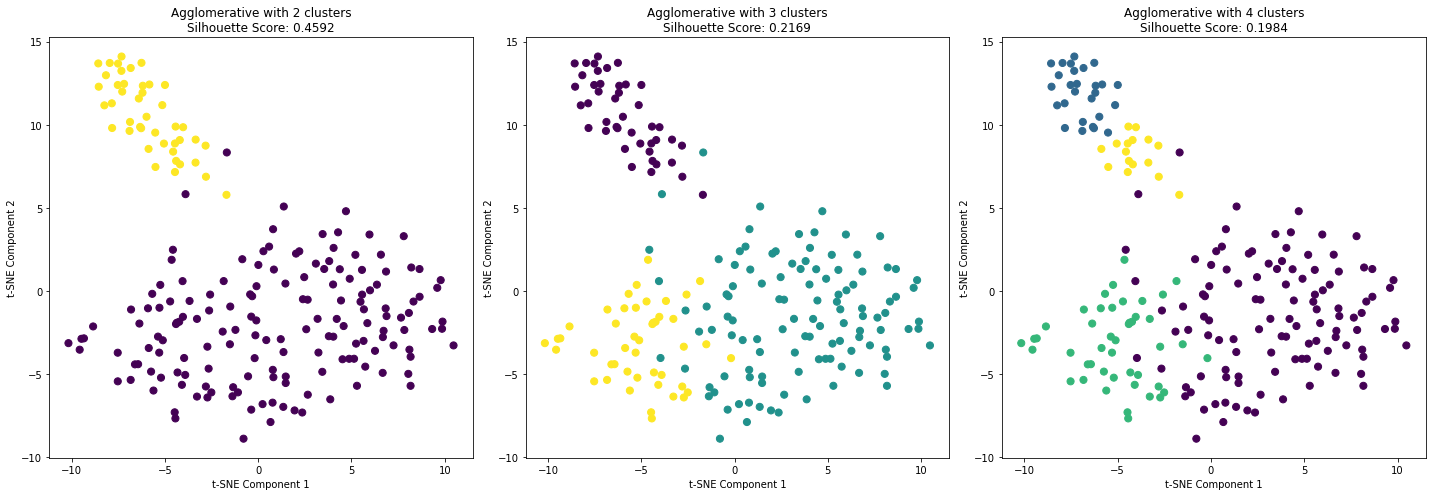

In [61]:
my_cluster.apply_kmeans(X=first_technique_4['eeg_data'], y=first_technique_4['y'])
my_cluster.apply_agglomerative(X=first_technique_4['eeg_data'], y=first_technique_4['y'])

##### Secnod File

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:01<00:00, 14.47it/s]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
    cluster_threshold  clusters     score
0                   2         2  0.106200
1                   3         3  0.105853
22                 24        24  0.096307
-------------------------------
Number of clusters for the top 3 scores: [ 2  3 24]
Purity for model 1 with 2 clusters: 0.5500
Purity for model 2 with 3 clusters: 0.7250
Purity for model 3 with 24 clusters: 0.7700


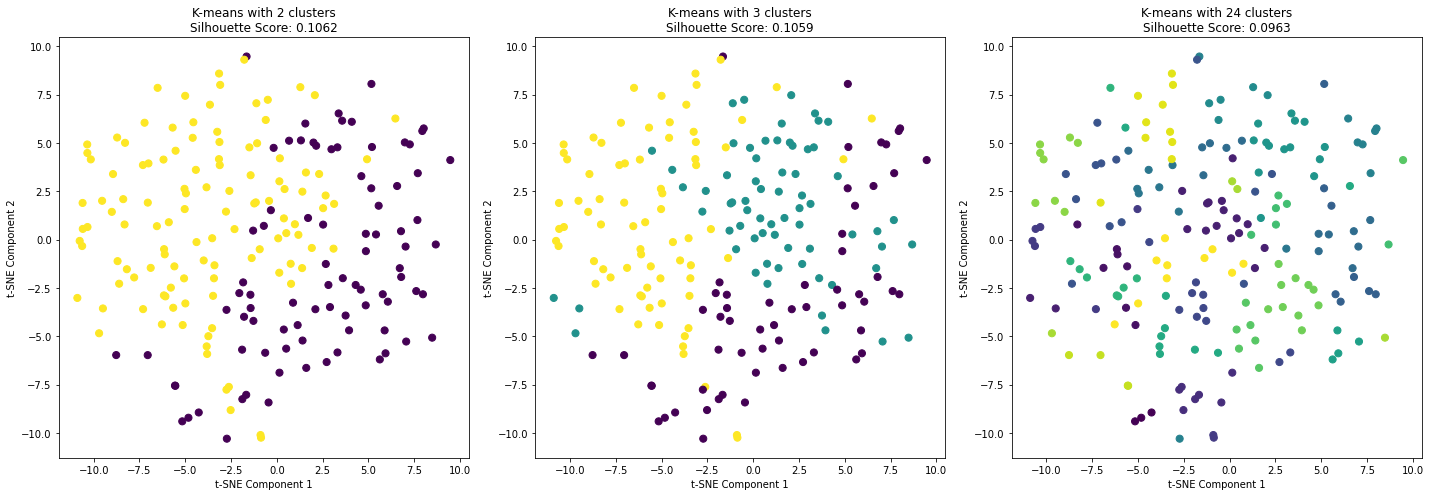

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 536.31it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [24].
[clusteval] >INFO> Fin.
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


-------------------------------
Top 3 scores:
    cluster_threshold  clusters     score
22                 24        24  0.086690
21                 23        23  0.086203
20                 22        22  0.084177
-------------------------------
Number of clusters for the top 3 scores: [24 23 22]
Purity for model 1 with 24 clusters: 0.7700
Purity for model 2 with 23 clusters: 0.7700
Purity for model 3 with 22 clusters: 0.7700


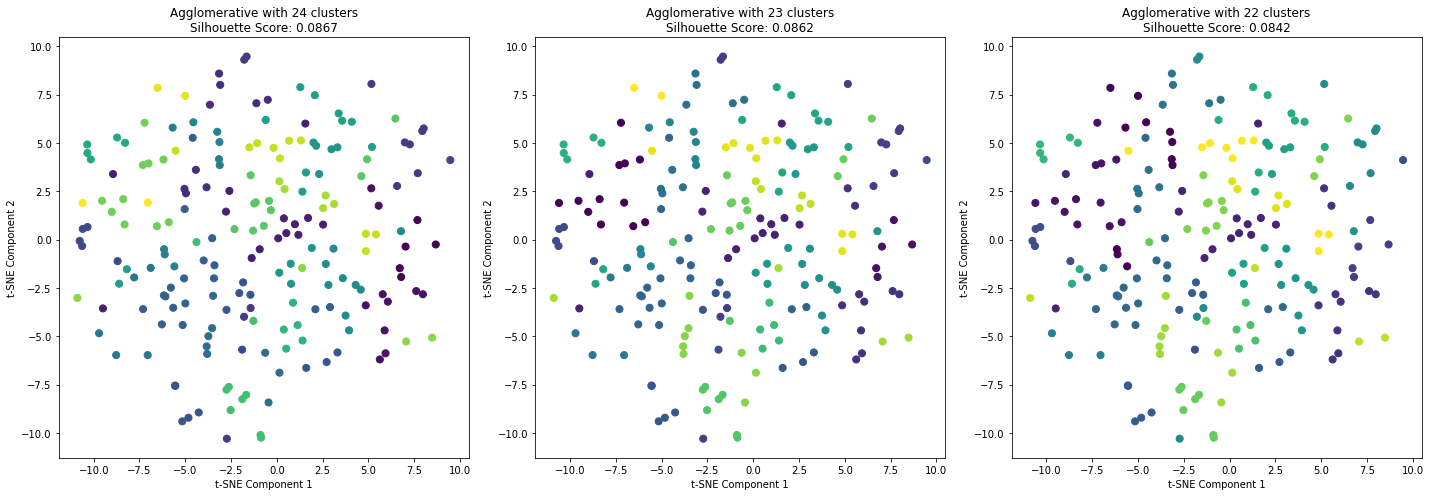

In [62]:
my_cluster.apply_kmeans(X=second_technique_4['eeg_data'], y=second_technique_4['y'])
my_cluster.apply_agglomerative(X=second_technique_4['eeg_data'], y=second_technique_4['y'])